# Détection de contours sur des images d'armes

## Détecteur de Canny

En s'inspirant des techniques vues en cours VISORD (Lab 3), nous avons implémenté un filtre de Canny afin de l'appliquer aux images d'armes.
Les étapes suivies sont les suivantes :
 + Lissage par un filtre gaussien.
 + Calcul des gradients.
 + Supression des non-maxima.
 + Seuillage.
 + Seuillage par hysterésis.
 
### Ouverture des images

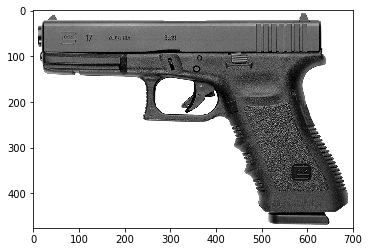

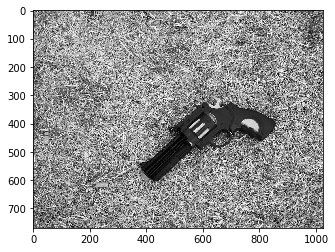

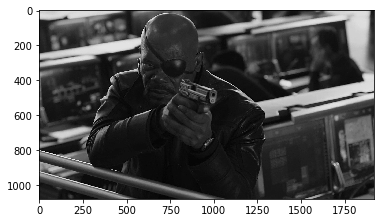

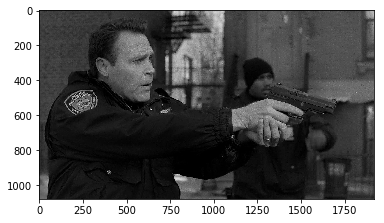

In [65]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

# open an image from a file
def open(img, gray=False):
    if gray:
        img = cv2.imread(img,0)
        plt.imshow(img,interpolation='nearest', cmap='gray')

    else:
        img = cv2.imread(img,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img,interpolation='nearest')

    plt.show()
    return img

PF = './data/'
img1 = open(PF+'handgun1.jpg', True)
img2 = open(PF+'handgun2.jpg', True)
img3 = open(PF+'handgun3.jpg', True)
img4 = open(PF+'handgun4.jpg', True)

### Lissage par un filtre gaussien

On utilise la fonction **GaussianBlur** d'OpenCV (documentation [ici](https://docs.opencv.org/3.1.0/d4/d13/tutorial_py_filtering.html)) pour convoluer une image par un filtre gaussien de taille de noyau 3 et avec $\sigma=1$. 


In [86]:
# on choisit l'image a tester
file = img2

(<matplotlib.axes._subplots.AxesSubplot at 0x1200ef320>,
 Text(0.5, 1.0, 'GaussianBlur'))

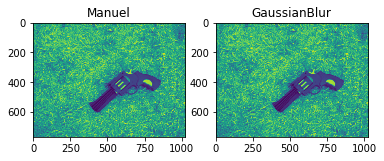

In [85]:
# creation du noyau gaussien manuellement
kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(file,-1,kernel)
plt.subplot(121),plt.imshow(dst),plt.title('Manuel')

# application de la fonction GaussianBlur
blur = cv2.GaussianBlur(file,(5,5), 5)
plt.subplot(122),plt.imshow(blur),plt.title('GaussianBlur')


On teste avec différentes tailles de noyau et différentes valeurs de $\sigma$.

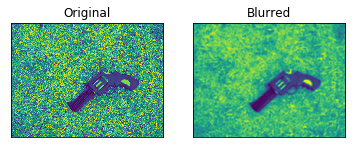

In [74]:
kernel_size = 13
sigma = 10

blur = cv2.GaussianBlur(file,(kernel_size, kernel_size), sigma)

plt.subplot(121),plt.imshow(file),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

### Calcul des gradients

On utilise les fonctions d'OpenCV et notamment le filtre de Sobel sur l'image d'origine. Documentation [ci-jointe](https://docs.opencv.org/3.2.0/d5/d0f/tutorial_py_gradients.html).


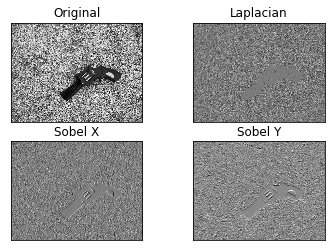

In [75]:
kernel_size = 13
sigma = 10

laplacian = cv2.Laplacian(file,cv2.CV_64F)
sobelx = cv2.Sobel(file,cv2.CV_64F,1,0,ksize=kernel_size)
sobely = cv2.Sobel(file,cv2.CV_64F,0,1,ksize=kernel_size)
plt.subplot(2,2,1),plt.imshow(file,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

###  Suppression des non-maxima

Le principe (par discrétisation de la direction) est le suivant :
 + Arrondir la direction du gradient avec un voisinage de 8 (plus proche 45 degrés).
 + Comparer la force du gradient du pixel courant avec celle qui se trouve dans la direction arrondie positive et négative du gradient.
 + Conserver le pixel si sa force est plus grande que ses deux voisins dans la direction du gradient.



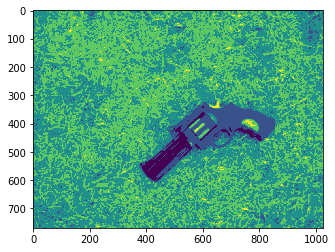

In [76]:
kernel = np.ones((5,5),np.float32)/1500
dst = cv2.filter2D(file,-1,kernel)
plt.imshow(dst)

### Seuillage

Le detecteur de Canny utilise un double seuillage. Les pixels dont la force du contour est au dessus d'un premier seuil (seuil haut) sont conservés. Les pixels dont la force du contour est en dessous du deuxième seuil (seuil bas) sont supprimés. Les pixels restant sont considérés comme pixels faibles.  Mettre en oeuvre ce principe.


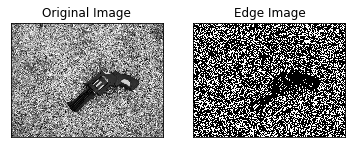

In [113]:
low_threshold = 100
high_threshold = 150

edges = cv2.Canny(file,low_threshold, high_threshold)

plt.subplot(121),plt.imshow(file, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Seuillage par hysterésis

Le principe consiste à ne garder que les pixels faibles qui sont dans le voisinage de pixels forts. Mettre en oeuvre ce principe avec une taille de voisinage pouvant se paramétrer.


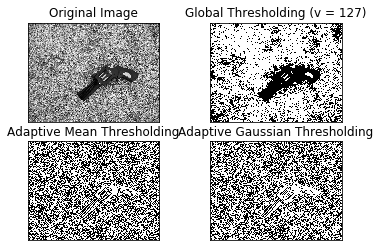

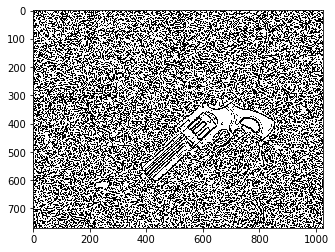

In [94]:
import time

blur = cv2.medianBlur(file,5)
ret,th1 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']

images = [file, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


def hysteresis(img):
    blur = cv2.medianBlur(img,5)
    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    plt.imshow(th3, cmap = 'gray')

plt.imshow(file,interpolation='nearest', cmap='gray')
hysteresis(file)

### Détecteur de Canny 

On teste le détecteur de Canny ainsi créé sur plusieurs images. OpenCV a aussi son propre détecteur de Canny (voir [ici](https://docs.opencv.org/3.3.1/da/d22/tutorial_py_canny.html)).

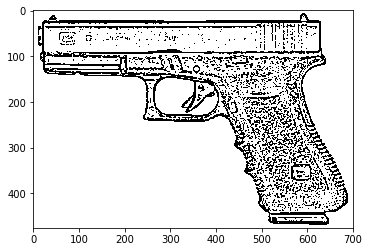

In [88]:
hysteresis(img1)

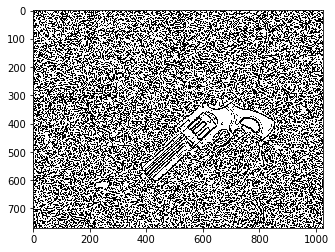

In [89]:
hysteresis(img2)

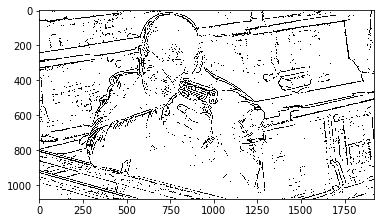

In [90]:
hysteresis(img3)

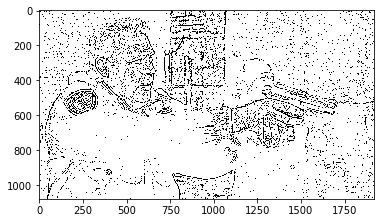

In [91]:
hysteresis(img4)

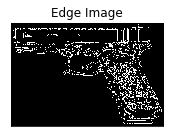

In [140]:
edges = cv2.Canny(img1, 50, 255)

plt.subplot(122),plt.imshow(edges, cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

On peut remarquer que les seuils hauts et bas dépendent vraiment de l'image et de ce qu'on veut y détecter.